In [4]:
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import dask.dataframe as dd
import dask.array as da
import dask.bag as db

In [6]:
import skimage
print(skimage.__version__)

0.19.2


# Loading Image

In [28]:
img = skimage.io.imread('/gpfs/commons/groups/nygcfaculty/PySeq/20210428_mouse_genotype_2/segmented_sections/m387ntgb1_labels.tiff')
## LOOK INTO GFAP

In [8]:
#from pyseq import image_analysis as ia
#im = ia.get_HiSeqImages(image_path = 'zarrs/m387ntga2.zarr')

In [9]:
#im.im

In [10]:
#img = plt.imread('/gpfs/commons/groups/nygcfaculty/PySeq/20210428_mouse_genotype_2/segmented_sections/m387ntgb1_labels.tiff')
#plt.imshow(img[:, :, 2])

In [11]:
#img[:,:,0][img[:,:,0] == 5]


In [29]:
#using region props:
ski_img = skimage.measure.regionprops(img)

In [30]:
import pandas as pd
df = pd.DataFrame(ski_img)
var_array = df.head(1).values

In [31]:
var_array

array([['area', 'area_bbox', 'area_convex', 'area_filled',
        'axis_major_length', 'axis_minor_length', 'bbox', 'centroid',
        'centroid_local', 'coords', 'eccentricity',
        'equivalent_diameter_area', 'euler_number', 'extent',
        'feret_diameter_max', 'image', 'image_convex', 'image_filled',
        'inertia_tensor', 'inertia_tensor_eigvals', 'label', 'moments',
        'moments_central', 'moments_hu', 'moments_normalized',
        'orientation', 'perimeter', 'perimeter_crofton', 'slice',
        'solidity']], dtype=object)

In [34]:
list_var = list(var_array.flatten())
lables = len(ski_img)

In [36]:
ski_img

 ...]

In [37]:
df = pd.DataFrame()
df.index = list_var

In [38]:
df = pd.DataFrame(index = list_var, columns = np.arange(1,lables,1))

In [43]:
v = df.columns.values

In [50]:
v[v == 11000]

array([], dtype=int64)

In [19]:
#df.head()

In [20]:
#df.loc['area',1] = 2
for ind in df.index:
    for val in df.columns:
        df.loc[ind,val] = getattr(ski_img[val],ind)
        

In [21]:
for val in df.columns:
    df.loc['bbox',val] = np.asarray(df.loc['bbox',val]).reshape(1,4)

In [48]:
for val in df.columns:
    df.loc['centroid',val] = np.asarray(df.loc['centroid',val]).reshape(1,2)

In [29]:
#df = df.drop('slice', axis = 0)

In [49]:
for ind in df.index:
    for val in df.columns:
        if type(df.loc[ind,val]) == np.ndarray:
            df.loc[ind,val] = df.loc[ind,val][~np.isnan(df.loc[ind,val])].flatten()
            
                    

In [50]:
scalar_list = ['area','area_bbox','area_convex','area_filled','axis_major_length','axis_minor_length',
            'eccentricity', 'equivalent_diameter_area','euler_number','extent','feret_diameter_max',
              'label','orientation','perimeter','perimeter_crofton','solidity'] 
scalar_df = df.loc[['area','area_bbox','area_convex','area_filled','axis_major_length','axis_minor_length',
            'eccentricity', 'equivalent_diameter_area','euler_number','extent','feret_diameter_max',
              'label','orientation','perimeter','perimeter_crofton','solidity']]
                   
multidim_list = ['bbox','centroid','centroid_local', 'coords', 'image', 'image_convex', 'image_filled',
                'inertia_tensor', 'inertia_tensor_eigvals', 'moments', 'moments_central' ,'moments_hu',
                'moments_normalized']
multidim_df = df.loc[['bbox','centroid','centroid_local', 'coords', 'image', 'image_convex', 'image_filled',
                'inertia_tensor', 'inertia_tensor_eigvals', 'moments', 'moments_central' ,'moments_hu',
                'moments_normalized']]

In [32]:
multidim_df.to_csv('multidim_df.csv')
scalar_df.to_csv('scalar_df.csv')

# Creating Anndata Object

In [51]:
# Create Anndata Object
import anndata as ad

In [52]:
mt = multidim_df.transpose()
type(mt)

pandas.core.frame.DataFrame

In [35]:
obs = pd.DataFrame()
obs['sample'] = scalar_df.columns
var_names = scalar_df.index
# dataframe for annotating the variables
var = pd.DataFrame(index=var_names)
# the data matrix 
X = scalar_df.T.values
obsm = multidim_df.T.values
adata = ad.AnnData(X, obs = obs,  var = var )

/gpfs/commons/home/jsingh/.conda/envs/spatial/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [53]:
X = scalar_df.T.values
adata = ad.AnnData(X)
adata.var_names = scalar_df.index
adata.obs_names = scalar_df.columns
adata.var = pd.DataFrame(index = scalar_list, columns = scalar_list)
adata.obs = pd.DataFrame(index = scalar_df.columns, columns = scalar_df.columns)
for col in mt.columns:
    adata.obsm[col] = mt[col].values

/gpfs/commons/home/jsingh/.conda/envs/spatial/lib/python3.9/site-packages/anndata/_core/anndata.py:875: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [1, 2, 3, 4, 5]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/gpfs/commons/home/jsingh/.conda/envs/spatial/lib/python3.9/site-packages/anndata/_core/anndata.py:801: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [1, 2, 3, 4, 5]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [54]:
adata

AnnData object with n_obs × n_vars = 9630 × 16
    obs: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 21

In [55]:
i = 0
for row in multidim_list:
    adata.uns[row] = multidim_df.iloc[[i]].values.flatten()
    i = i+1
    

In [56]:
adata

AnnData object with n_obs × n_vars = 9630 × 16
    obs: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 21

In [129]:
adata.uns['centroid'][9629]

array([8608.47619048, 9474.15750916])

In [1]:
#adata.write('segmented_section')

# Rough Work

In [53]:
# Centroid Distance Matrix
x_coord = []
y_coord = []
for x in range(np.shape(adata.uns['centroid'])[0]):
    x_coord.append(adata.uns['centroid'][x][0])
    y_coord.append(adata.uns['centroid'][x][1])
    
    

In [55]:
import scipy
dist_mat = scipy.spatial.distance.cdist(mat,mat) 

In [56]:
pd.DataFrame(dist_mat)

0            1            2            3            4     \
0         0.000000  1298.342013  1313.798639  1305.827533  1301.047119   
1      1298.342013     0.000000    33.198836    12.660053    32.803880   
2      1313.798639    33.198836     0.000000    40.527127    63.585299   
3      1305.827533    12.660053    40.527127     0.000000    23.066980   
4      1301.047119    32.803880    63.585299    23.066980     0.000000   
...            ...          ...          ...          ...          ...   
9625  10255.496135  9140.535439  9111.814275  9139.843168  9156.403445   
9626  10244.304235  9117.672744  9089.270188  9116.742994  9132.998858   
9627  10250.400382  9123.241382  9094.854114  9122.300414  9138.541728   
9628  10254.207181  9126.737339  9098.359113  9125.789745  9142.022456   
9629  10825.832103  9705.454147  9676.911602  9704.626556  9721.012601   

             5            6            7            8            9     ...  \
0     1314.422229  1321.087075  1329.222795  1351.198145  1351.965747  ...   
1       19.584311    23.516974    35.790094    54.614926    54.314662  ...   
2       18.328219    24.725134    50.346611    40.735044    54.331921  ...   
3       23.139480    22.322224    24.665431    51.422778    46.171694  ...   
4       46.067885    43.810761    31.905078    68.809033    56.600295  ...   
...           ...          ...          ...          ...          ...  ...   
9625  9120.965662  9118.171880  9124.683288  9088.599640  9100.362656  ...   
9626  9098.120627  9095.176245  9101.219852  9065.427715  9076.818632  ...   
9627  9103.690270  9100.738798  9106.760213  9070.982193  9082.355389  ...   
9628  9107.186829  9104.231168  9110.239470  9074.469804  9085.832526  ...   
9629  9685.893538  9683.014010  9689.257061  9653.339720  9664.888690  ...   

             9620          9621          9622          9623          9624  \
0     9995.129889  10000.145697  10212.128369  10240.056721  10249.750787   
1     8895.135813   8898.985891   9115.087762   9127.601755   9137.375665   
2     8866.016906   8869.895952   9085.910624   9098.813664   9108.586078   
3     8894.752263   8898.579421   9114.750019   9126.960427   9136.735457   
4     8911.699830   8915.498630   9131.753466   9143.585251   9153.361670   
...           ...           ...           ...           ...           ...   
9625   329.513174    315.922294    257.061603     39.002259     37.763815   
9626   448.063295    432.093730    426.825127    208.468092    210.084228   
9627   457.874198    441.910006    435.119490    216.441750    217.788330   
9628   463.779588    447.820134    440.064054    221.228683    222.415668   
9629   873.325852    863.618927    693.512142    594.175800    584.892023   

              9625          9626          9627          9628          9629  
0     10255.496135  10244.304235  10250.400382  10254.207181  10825.832103  
1      9140.535439   9117.672744   9123.241382   9126.737339   9705.454147  
2      9111.814275   9089.270188   9094.854114   9098.359113   9676.911602  
3      9139.843168   9116.742994   9122.300414   9125.789745   9704.626556  
4      9156.403445   9132.998858   9138.541728   9142.022456   9721.012601  
...            ...           ...           ...           ...           ...  
9625      0.000000    173.121927    180.596649    185.107325    573.783936  
9626    173.121927      0.000000      9.828609     15.754771    592.736629  
9627    180.596649      9.828609      0.000000      5.927584    588.365005  
9628    185.107325     15.754771      5.927584      0.000000    585.645020  
9629    573.783936    592.736629    588.365005    585.645020      0.000000  

[9630 rows x 9630 columns]

In [57]:
dist_mat = scipy.spatial.distance.pdist(mat, 'correlation') 
pd.DataFrame(scipy.spatial.distance.squareform(dist_mat))

0     1     2     3     4     5             6             7     8     \
0      0.0   0.0   0.0   0.0   0.0   0.0  0.000000e+00  1.110223e-16   0.0   
1      0.0   0.0   0.0   0.0   0.0   0.0  0.000000e+00  0.000000e+00   0.0   
2      0.0   0.0   0.0   0.0   0.0   0.0  0.000000e+00  0.000000e+00   0.0   
3      0.0   0.0   0.0   0.0   0.0   0.0  1.110223e-16  0.000000e+00   0.0   
4      0.0   0.0   0.0   0.0   0.0   0.0  0.000000e+00  0.000000e+00   0.0   
...    ...   ...   ...   ...   ...   ...           ...           ...   ...   
9625   2.0   2.0   2.0   2.0   2.0   2.0  2.000000e+00  2.000000e+00   2.0   
9626   2.0   2.0   2.0   2.0   2.0   2.0  2.000000e+00  2.000000e+00   2.0   
9627   2.0   2.0   2.0   2.0   2.0   2.0  2.000000e+00  2.000000e+00   2.0   
9628   2.0   2.0   2.0   2.0   2.0   2.0  2.000000e+00  2.000000e+00   2.0   
9629   2.0   2.0   2.0   2.0   2.0   2.0  2.000000e+00  2.000000e+00   2.0   

      9     ...          9620  9621  9622          9623          9624  \
0      0.0  ...  2.000000e+00   2.0   2.0  2.000000e+00  2.000000e+00   
1      0.0  ...  2.000000e+00   2.0   2.0  2.000000e+00  2.000000e+00   
2      0.0  ...  2.000000e+00   2.0   2.0  2.000000e+00  2.000000e+00   
3      0.0  ...  2.000000e+00   2.0   2.0  2.000000e+00  2.000000e+00   
4      0.0  ...  2.000000e+00   2.0   2.0  2.000000e+00  2.000000e+00   
...    ...  ...           ...   ...   ...           ...           ...   
9625   2.0  ...  1.110223e-16   0.0   0.0  0.000000e+00  1.110223e-16   
9626   2.0  ...  0.000000e+00   0.0   0.0  0.000000e+00  0.000000e+00   
9627   2.0  ...  0.000000e+00   0.0   0.0  2.220446e-16  0.000000e+00   
9628   2.0  ...  0.000000e+00   0.0   0.0  0.000000e+00  0.000000e+00   
9629   2.0  ...  0.000000e+00   0.0   0.0  0.000000e+00  1.110223e-16   

              9625  9626  9627          9628  9629  
0     2.000000e+00   2.0   2.0  2.000000e+00   2.0  
1     2.000000e+00   2.0   2.0  2.000000e+00   2.0  
2     2.000000e+00   2.0   2.0  2.000000e+00   2.0  
3     2.000000e+00   2.0   2.0  2.000000e+00   2.0  
4     2.000000e+00   2.0   2.0  2.000000e+00   2.0  
...            ...   ...   ...           ...   ...  
9625  0.000000e+00   0.0   0.0  2.220446e-16   0.0  
9626  0.000000e+00   0.0   0.0  0.000000e+00   0.0  
9627  0.000000e+00   0.0   0.0  0.000000e+00   0.0  
9628  2.220446e-16   0.0   0.0  0.000000e+00   0.0  
9629  0.000000e+00   0.0   0.0  0.000000e+00   0.0  

[9630 rows x 9630 columns]

In [58]:
scipy.cluster.vq.kmeans(mat, 10)

(array([[1951.52264661, 2451.33710919],
        [6547.42510169, 5346.20186136],
        [8600.65752662, 5574.83007672],
        [4493.84433584, 5449.19804433],
        [5186.0733471 , 3030.96957284],
        [5862.03291672, 7547.10532103],
        [2453.68775632, 4299.99916396],
        [7314.00575967, 3418.24688998],
        [7768.62036112, 7684.52096548],
        [3155.15720768, 1568.91343383]]),
 720.9927291479689)

In [59]:
import shapely.geometry
polys = []
for ix in range(np.shape(adata.uns['centroid'])[0]):
    box = adata.uns['bbox'][ix]
    polygon = shapely.geometry.box(box[0],box[1],box[2],box[3],ccw=True)
    polys.append(polygon)

In [60]:
import geopandas

/gpfs/commons/home/jsingh/.conda/envs/spatial/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [61]:
polys = geopandas.GeoSeries(polys)
gdf = geopandas.GeoDataFrame(
    {
        'geometry': polys, 
        'id': ['P-%s'%str(i).zfill(2) for i in range(len(polys))]
    }
)

In [62]:
np.save('centroid_matrix', mat)

In [63]:
gdf.to_file('bbox_polygon.shp')

/gpfs/commons/home/jsingh/.conda/envs/spatial/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


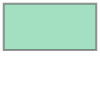

In [64]:
polys[100]

In [65]:
# Build a regular 3x3 lattice and draw it here
from pysal.lib import weights
wr = weights.contiguity.Rook.from_dataframe(gdf)

/gpfs/commons/home/jsingh/.conda/envs/spatial/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 9625 disconnected components.
 There are 9620 islands with ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 1

In [66]:
pd.DataFrame(*wr.full()).astype(int)

0     1     2     3     4     5     6     7     8     9     ...  9620  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
9625     0     0     0     0     0     0     0     0     0     0  ...     0   
9626     0     0     0     0     0     0     0     0     0     0  ...     0   
9627     0     0     0     0     0     0     0     0     0     0  ...     0   
9628     0     0     0     0     0     0     0     0     0     0  ...     0   
9629     0     0     0     0     0     0     0     0     0     0  ...     0   

      9621  9622  9623  9624  9625  9626  9627  9628  9629  
0        0     0     0     0     0     0     0     0     0  
1        0     0     0     0     0     0     0     0     0  
2        0     0     0     0     0     0     0     0     0  
3        0     0     0     0     0     0     0     0     0  
4        0     0     0     0     0     0     0     0     0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
9625     0     0     0     0     0     0     0     0     0  
9626     0     0     0     0     0     0     0     0     0  
9627     0     0     0     0     0     0     0     1     0  
9628     0     0     0     0     0     0     1     0     0  
9629     0     0     0     0     0     0     0     0     0  

[9630 rows x 9630 columns]

In [67]:
wm = np.array(pd.DataFrame(*wr.full()).astype(int))

In [68]:
wm[wm == 1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

KeyboardInterrupt: 

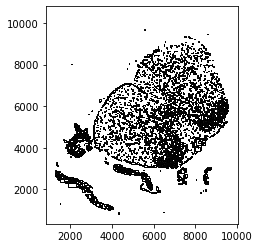

In [68]:
# Set up figure
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
# Plot grid
gdf.plot(facecolor='w', edgecolor='k', ax=ax)
# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x-.25 for p in polys],
    [p.centroid.y-.25 for p in polys],
    [i for i in gdf['id']]
):
    plt.text(
        x, y, t, verticalalignment='center', horizontalalignment='center'
    )
# Plot weights connectivity
wr.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
# Remove axes
ax.set_axis_off()

In [69]:
######
gdf['area'] = scalar_df.iloc[[0]].transpose()

In [70]:
gdf

geometry      id  area
0     POLYGON ((1525.000 1276.000, 1525.000 1324.000...    P-00   NaN
1     POLYGON ((2737.000 1746.000, 2737.000 1761.000...    P-01  1012
2     POLYGON ((2736.000 1782.000, 2736.000 1792.000...    P-02   147
3     POLYGON ((2743.000 1741.000, 2743.000 1754.000...    P-03    36
4     POLYGON ((2742.000 1724.000, 2742.000 1725.000...    P-04    90
...                                                 ...     ...   ...
9625  POLYGON ((8193.000 9079.000, 8193.000 9089.000...  P-9625   422
9626  POLYGON ((8320.000 8960.000, 8320.000 8965.000...  P-9626    39
9627  POLYGON ((8323.000 8960.000, 8323.000 8963.000...  P-9627    64
9628  POLYGON ((8332.000 8960.000, 8332.000 8963.000...  P-9628     8
9629  POLYGON ((8621.000 9461.000, 8621.000 9485.000...  P-9629    20

[9630 rows x 3 columns]

/gpfs/commons/home/jsingh/.conda/envs/spatial/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


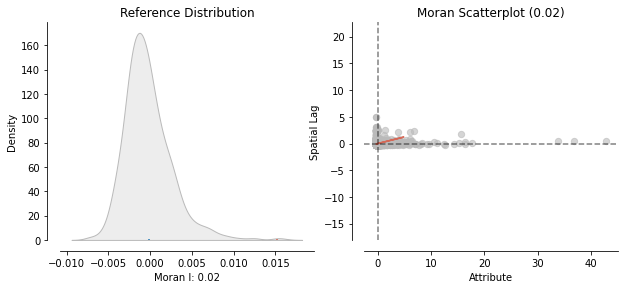

In [71]:
from libpysal.weights import Queen, Rook, KNN
from esda.moran import Moran
from splot.esda import plot_moran
w_knn = KNN.from_dataframe(gdf, k=20)
ar = gdf.area
moran = Moran(ar, w_knn)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

In [72]:
moran.p_norm

7.199961813419975e-07

In [73]:
gdf

geometry      id  area
0     POLYGON ((1525.000 1276.000, 1525.000 1324.000...    P-00   NaN
1     POLYGON ((2737.000 1746.000, 2737.000 1761.000...    P-01  1012
2     POLYGON ((2736.000 1782.000, 2736.000 1792.000...    P-02   147
3     POLYGON ((2743.000 1741.000, 2743.000 1754.000...    P-03    36
4     POLYGON ((2742.000 1724.000, 2742.000 1725.000...    P-04    90
...                                                 ...     ...   ...
9625  POLYGON ((8193.000 9079.000, 8193.000 9089.000...  P-9625   422
9626  POLYGON ((8320.000 8960.000, 8320.000 8965.000...  P-9626    39
9627  POLYGON ((8323.000 8960.000, 8323.000 8963.000...  P-9627    64
9628  POLYGON ((8332.000 8960.000, 8332.000 8963.000...  P-9628     8
9629  POLYGON ((8621.000 9461.000, 8621.000 9485.000...  P-9629    20

[9630 rows x 3 columns]

In [74]:
### Voronoi Transformation ###
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(mat)

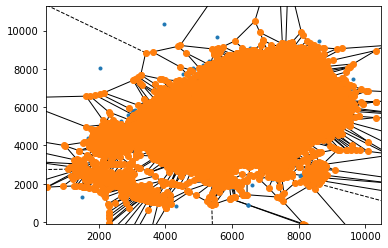

In [75]:
import matplotlib.pyplot as plt
>>> fig = voronoi_plot_2d(vor)
>>> plt.show()

In [76]:
def test_voronoi_plot_2d(vor, ax=None, **kw):
    """
    Plot the given Voronoi diagram in 2-D
    Parameters
    ----------
    vor : scipy.spatial.Voronoi instance
        Diagram to plot
    ax : matplotlib.axes.Axes instance, optional
        Axes to plot on
    show_points: bool, optional
        Add the Voronoi points to the plot.
    show_vertices : bool, optional
        Add the Voronoi vertices to the plot.
    line_colors : string, optional
        Specifies the line color for polygon boundaries
    line_width : float, optional
        Specifies the line width for polygon boundaries
    line_alpha: float, optional
        Specifies the line alpha for polygon boundaries
    point_size: float, optional
        Specifies the size of points
    Returns
    -------
    fig : matplotlib.figure.Figure instance
        Figure for the plot
    See Also
    --------
    Voronoi
    Notes
    -----
    Requires Matplotlib.
    Examples
    --------
    Set of point:
    >>> import matplotlib.pyplot as plt
    >>> rng = np.random.default_rng()
    >>> points = rng.random((10,2))
    Voronoi diagram of the points:
    >>> from scipy.spatial import Voronoi, voronoi_plot_2d
    >>> vor = Voronoi(points)
    using `voronoi_plot_2d` for visualisation:
    >>> fig = voronoi_plot_2d(vor)
    using `voronoi_plot_2d` for visualisation with enhancements:
    >>> fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange',
    ...                 line_width=2, line_alpha=0.6, point_size=2)
    >>> plt.show()
    """
    from matplotlib.collections import LineCollection


    line_colors = kw.get('line_colors', 'k')
    line_width = kw.get('line_width', 1.0)
    line_alpha = kw.get('line_alpha', 1.0)

    center = vor.points.mean(axis=0)
    ptp_bound = vor.points.ptp(axis=0)

    finite_segments = []
    infinite_segments = []
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            finite_segments.append(vor.vertices[simplex])
        else:
            i = simplex[simplex >= 0][0]  # finite end Voronoi vertex

            t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[pointidx].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            if (vor.furthest_site):
                direction = -direction
            far_point = vor.vertices[i] + direction * ptp_bound.max()

            infinite_segments.append([vor.vertices[i], far_point])
            
    print(finite_segments)


    return ax.figure

In [77]:
import matplotlib.pyplot as plt
fig = test_voronoi_plot_2d(vor)
plt.show()

[array([[ 7584.93414318, 17082.24010148],
       [ 4445.45597804,  9223.48189665]]), array([[3411.31334987, 8840.10803797],
       [3621.61507732, 8886.09785924]]), array([[3621.61507732, 8886.09785924],
       [4371.24061847, 9171.16393154]]), array([[4445.45597804, 9223.48189665],
       [4371.24061847, 9171.16393154]]), array([[8610.78996956, 1987.67285516],
       [8434.9882467 , 1964.0764198 ]]), array([[ 31768.30604855, -44989.33925247],
       [  8473.17085424,   1723.47035022]]), array([[8434.9882467 , 1964.0764198 ],
       [8473.17085424, 1723.47035022]]), array([[8173.41902399, -156.36885963],
       [8141.99033592,  -96.30590762]]), array([[8173.41902399, -156.36885963],
       [5951.94314282, 1225.37387059]]), array([[8141.99033592,  -96.30590762],
       [5952.14137048, 1225.49481927]]), array([[5951.94314282, 1225.37387059],
       [5952.14137048, 1225.49481927]]), array([[ 31768.30604855, -44989.33925247],
       [  8173.41902399,   -156.36885963]]), array([[8473.170854

AttributeError: 'NoneType' object has no attribute 'figure'

In [78]:
import pytess
voronoipolys = pytess.voronoi(mat)

In [79]:
type(voronoipolys)

list

In [80]:
polys = geopandas.GeoSeries(voronoipolys)

/tmp/ipykernel_128302/3777989138.py:1: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  polys = geopandas.GeoSeries(voronoipolys)


In [81]:
from shapely.geometry import Polygon

In [83]:
import shapely.geometry
import shapely.ops

In [84]:
vor

In [94]:
lines = [
    shapely.geometry.LineString(vor.vertices[line])
    for line in vor.ridge_vertices
    if -1 not in line
]

In [95]:
h=shapely.ops.polygonize(lines)

In [96]:
polygon_list = []
for pol in h:
    print(pol)
    polygon_list.append(pol)

POLYGON ((4445.4559780421 9223.481896654579, 7584.93414317989 17082.24010147902, 7436.613307222337 14874.6215085276, 7369.415396020358 14470.10014552203, 6683.577286397815 10495.17613557881, 6075.79166674128 9448.318838046638, 5731.025851959175 9161.137595379416, 5582.820996344954 9076.645782259287, 5543.527121576628 9056.885424619886, 5533.764407020106 9054.770340585947, 5410.785225430654 9041.725260637993, 4445.4559780421 9223.481896654579))
POLYGON ((3411.313349870077 8840.108037971853, 3621.615077322219 8886.097859237007, 4442.147298930437 8103.317309052864, 4635.275900298282 7746.977833459603, 4745.488487993863 7467.78019310564, 4555.618499491236 7407.077130255599, 4396.888177445649 7393.567373078018, 4317.202556494723 7388.651807072086, 3980.372545528355 7434.745996810516, 3886.35320583923 7462.546453193728, 3840.618274444308 7478.271479962226, 3263.984011342005 7690.990996437156, 3411.313349870077 8840.108037971853))
POLYGON ((3621.615077322219 8886.097859237007, 4371.2406184691

POLYGON ((5203.049270730879 7292.939464945303, 5152.175533471614 7293.191617059763, 5127.06769516835 7313.679596204769, 5120.738195432034 7338.416832624375, 5137.891763133849 7370.600000395646, 5149.344291246374 7381.50866679026, 5218.945635258122 7338.042431041272, 5224.771923495266 7300.726262510542, 5203.049270730879 7292.939464945303))
POLYGON ((5152.175533471614 7293.191617059763, 5203.049270730879 7292.939464945303, 5191.959772532495 7205.821191724531, 5148.895330717581 7281.958325513292, 5152.175533471614 7293.191617059763))
POLYGON ((5191.959772532495 7205.821191724531, 5203.049270730879 7292.939464945303, 5224.771923495266 7300.726262510542, 5310.191911159488 7273.339014052805, 5277.5986575492 7159.334775089286, 5218.864215488806 7141.652778070251, 5191.008194280659 7195.344156983716, 5191.959772532495 7205.821191724531))
POLYGON ((5148.895330717581 7281.958325513292, 5191.959772532495 7205.821191724531, 5191.008194280659 7195.344156983716, 5134.481237709027 7233.115254099373,

POLYGON ((5669.492245475433 3132.899191180628, 5669.227587404288 3129.458636255747, 5651.657616099071 3108.527151702787, 5642.818181818182 3135.045454545455, 5645.599202039641 3141.998005099103, 5669.492245475433 3132.899191180628))
POLYGON ((5706.701801119705 3159.605403359116, 5669.492245475433 3132.899191180628, 5645.599202039641 3141.998005099103, 5619.327106536064 3175.708384665864, 5670.704947834945 3246.202736808603, 5692.407010958097 3251.461176947216, 5727.729709890589 3185.619296786174, 5727.836770425467 3181.663397884066, 5717.046925764683 3168.821660638549, 5706.701801119705 3159.605403359116))
POLYGON ((5012.448514672325 3650.329692907636, 5089.033662510007 3543.2376480951, 5085.919943633625 3534.260034633071, 4963.773126384455 3603.712016569085, 5012.448514672325 3650.329692907636))
POLYGON ((5099.057816114269 3669.532814565697, 5024.875290679653 3668.329220544646, 5018.75916628555 3683.229675925046, 5002.485410349329 3755.326144805411, 5090.476743602558 3807.185838099264

POLYGON ((6814.357977794792 5435.368924394453, 6825.61833281102 5418.248364168632, 6797.027680832005 5402.039137278294, 6719.637652802659 5411.541940390503, 6719.972224210567 5414.337905626627, 6726.878557394344 5425.6533111671, 6814.357977794792 5435.368924394453))
POLYGON ((6797.027680832005 5402.039137278294, 6825.61833281102 5418.248364168632, 6889.536317041973 5402.366066030677, 6893.997175052436 5399.460409865485, 6894.617928246254 5362.068187142479, 6795.279282767444 5376.897230528562, 6797.027680832005 5402.039137278294))
POLYGON ((6719.637652802659 5411.541940390503, 6797.027680832005 5402.039137278294, 6795.279282767444 5376.897230528562, 6792.861656461308 5367.792473073656, 6711.870531224086 5397.004945367282, 6719.637652802659 5411.541940390503))
POLYGON ((6719.972224210567 5414.337905626627, 6719.637652802659 5411.541940390503, 6711.870531224086 5397.004945367282, 6695.258941130038 5371.988867532105, 6641.542404787013 5381.386551246471, 6630.359562530201 5387.498816670211,

POLYGON ((6839.794291233542 5278.233673163656, 6804.200543234259 5253.978031403813, 6793.159170772977 5262.289256357734, 6804.204271521408 5282.580208862622, 6814.103676210259 5290.195135546353, 6839.794291233542 5278.233673163656))
POLYGON ((6795.66325876785 5336.540803074528, 6813.96576724764 5333.099731997946, 6814.103676210259 5290.195135546353, 6804.204271521408 5282.580208862622, 6761.839772605474 5324.705458275759, 6795.66325876785 5336.540803074528))
POLYGON ((6761.839772605474 5324.705458275759, 6804.204271521408 5282.580208862622, 6793.159170772977 5262.289256357734, 6738.358204911177 5260.256866764809, 6731.083026793146 5319.072223475969, 6761.839772605474 5324.705458275759))
POLYGON ((6894.834461904896 5353.723149862052, 6894.930086354735 5356.491876309047, 6975.124006840901 5372.369770652756, 6998.011697426215 5337.431010330662, 6940.431378950901 5309.084281375914, 6903.523857765946 5334.34509464343, 6894.834461904896 5353.723149862052))
POLYGON ((6695.258941130038 5371.98

POLYGON ((5818.4837439136 4662.66720136152, 5873.216936220932 4590.110463443168, 5872.608573733138 4588.97399090419, 5798.752331301598 4575.605469870389, 5789.728941315418 4656.647998807732, 5803.079423212152 4671.730154861168, 5818.4837439136 4662.66720136152))
POLYGON ((5696.5126815542 4682.568973151484, 5718.71881342577 4723.044262302608, 5726.893977321435 4673.993278928513, 5696.5126815542 4682.568973151484))
POLYGON ((5718.71881342577 4723.044262302608, 5696.5126815542 4682.568973151484, 5692.799545207673 4678.599523629817, 5672.53558575132 4661.046118173085, 5651.740723944621 4671.310534382251, 5691.168669376462 4804.860787015807, 5742.885258169541 4768.202494138529, 5718.71881342577 4723.044262302608))
POLYGON ((5696.5126815542 4682.568973151484, 5726.893977321435 4673.993278928513, 5784.792804811671 4654.221813263141, 5766.543706815489 4642.54642459397, 5692.799545207673 4678.599523629817, 5696.5126815542 4682.568973151484))
POLYGON ((5726.893977321435 4673.993278928513, 5718.7

POLYGON ((2813.763775881958 4495.10540050716, 2788.689580460107 4507.118645639281, 2790.356464858817 4519.431291552427, 2802.160785993754 4533.947416191337, 2813.763775881958 4495.10540050716))
POLYGON ((2790.356464858817 4519.431291552427, 2788.689580460107 4507.118645639281, 2773.907224250185 4504.110237141956, 2767.883145043646 4513.306253321238, 2758.698857609854 4544.103344473573, 2790.356464858817 4519.431291552427))
POLYGON ((2741.028316282401 4475.530644182299, 2729.428886736604 4488.58000242132, 2727.92456760255 4497.611270674523, 2767.883145043646 4513.306253321238, 2773.907224250185 4504.110237141956, 2758.406466554884 4464.499439800506, 2741.028316282401 4475.530644182299))
POLYGON ((2839.514211849398 4420.747200479919, 2843.507382924608 4434.680454059944, 2844.818467208129 4434.865548311736, 2859.862723640354 4402.862723640354, 2847.282710280374 4390.282710280374, 2835.483549959383 4397.906783103168, 2839.514211849398 4420.747200479919))
POLYGON ((2843.507382924608 4434.68

In [104]:
poly_df = geopandas.GeoDataFrame(geopandas.GeoSeries(polygon_list))

In [108]:
gdf2 = geopandas.GeoDataFrame(
    {
        'geometry': polygon_list, 
        'id': ['P-%s'%str(i).zfill(2) for i in range(len(polygon_list))]
    }
)

<AxesSubplot:>

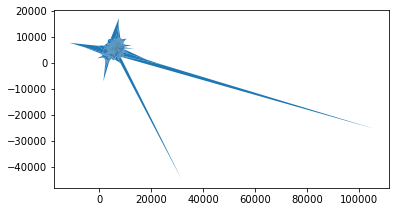

In [111]:
gdf2.plot()